#YouTube 動画視聴回数予測　コンペ

## データの読み込み

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train = pd.read_csv("/content/drive/My Drive/遊び/Youtube/train_data.csv")
test = pd.read_csv("/content/drive/My Drive/遊び/Youtube/test_data.csv")

train_x = train.drop(['y'],axis=1)
train_y = np.log1p(train['y']) 
df = pd.concat([train_x, test])

test_x = test.copy()

## データの確認

In [30]:
train.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,False,False,I look so bad but look at me!,34826
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,False,False,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727


## 前処理

In [41]:
for c in ['comments_disabled','ratings_disabled']: #,'tags'
  le = LabelEncoder()
  le.fit(train_x[c].fillna('NA'))
  df[c] = le.transform(df[c].fillna('NA'))
for c in ['publishedAt','channelId','channelTitle','collection_date']:
  freq = train_x[c].value_counts()
  df[c] = df[c].map(freq)

del df["video_id"]
del df["title"]
del df["description"]
del df["thumbnail_link"]
del df["tags"]
del df["id"]


train_x = df.iloc[:len(train_y), :]
test_x = df.iloc[len(train_y):, :]

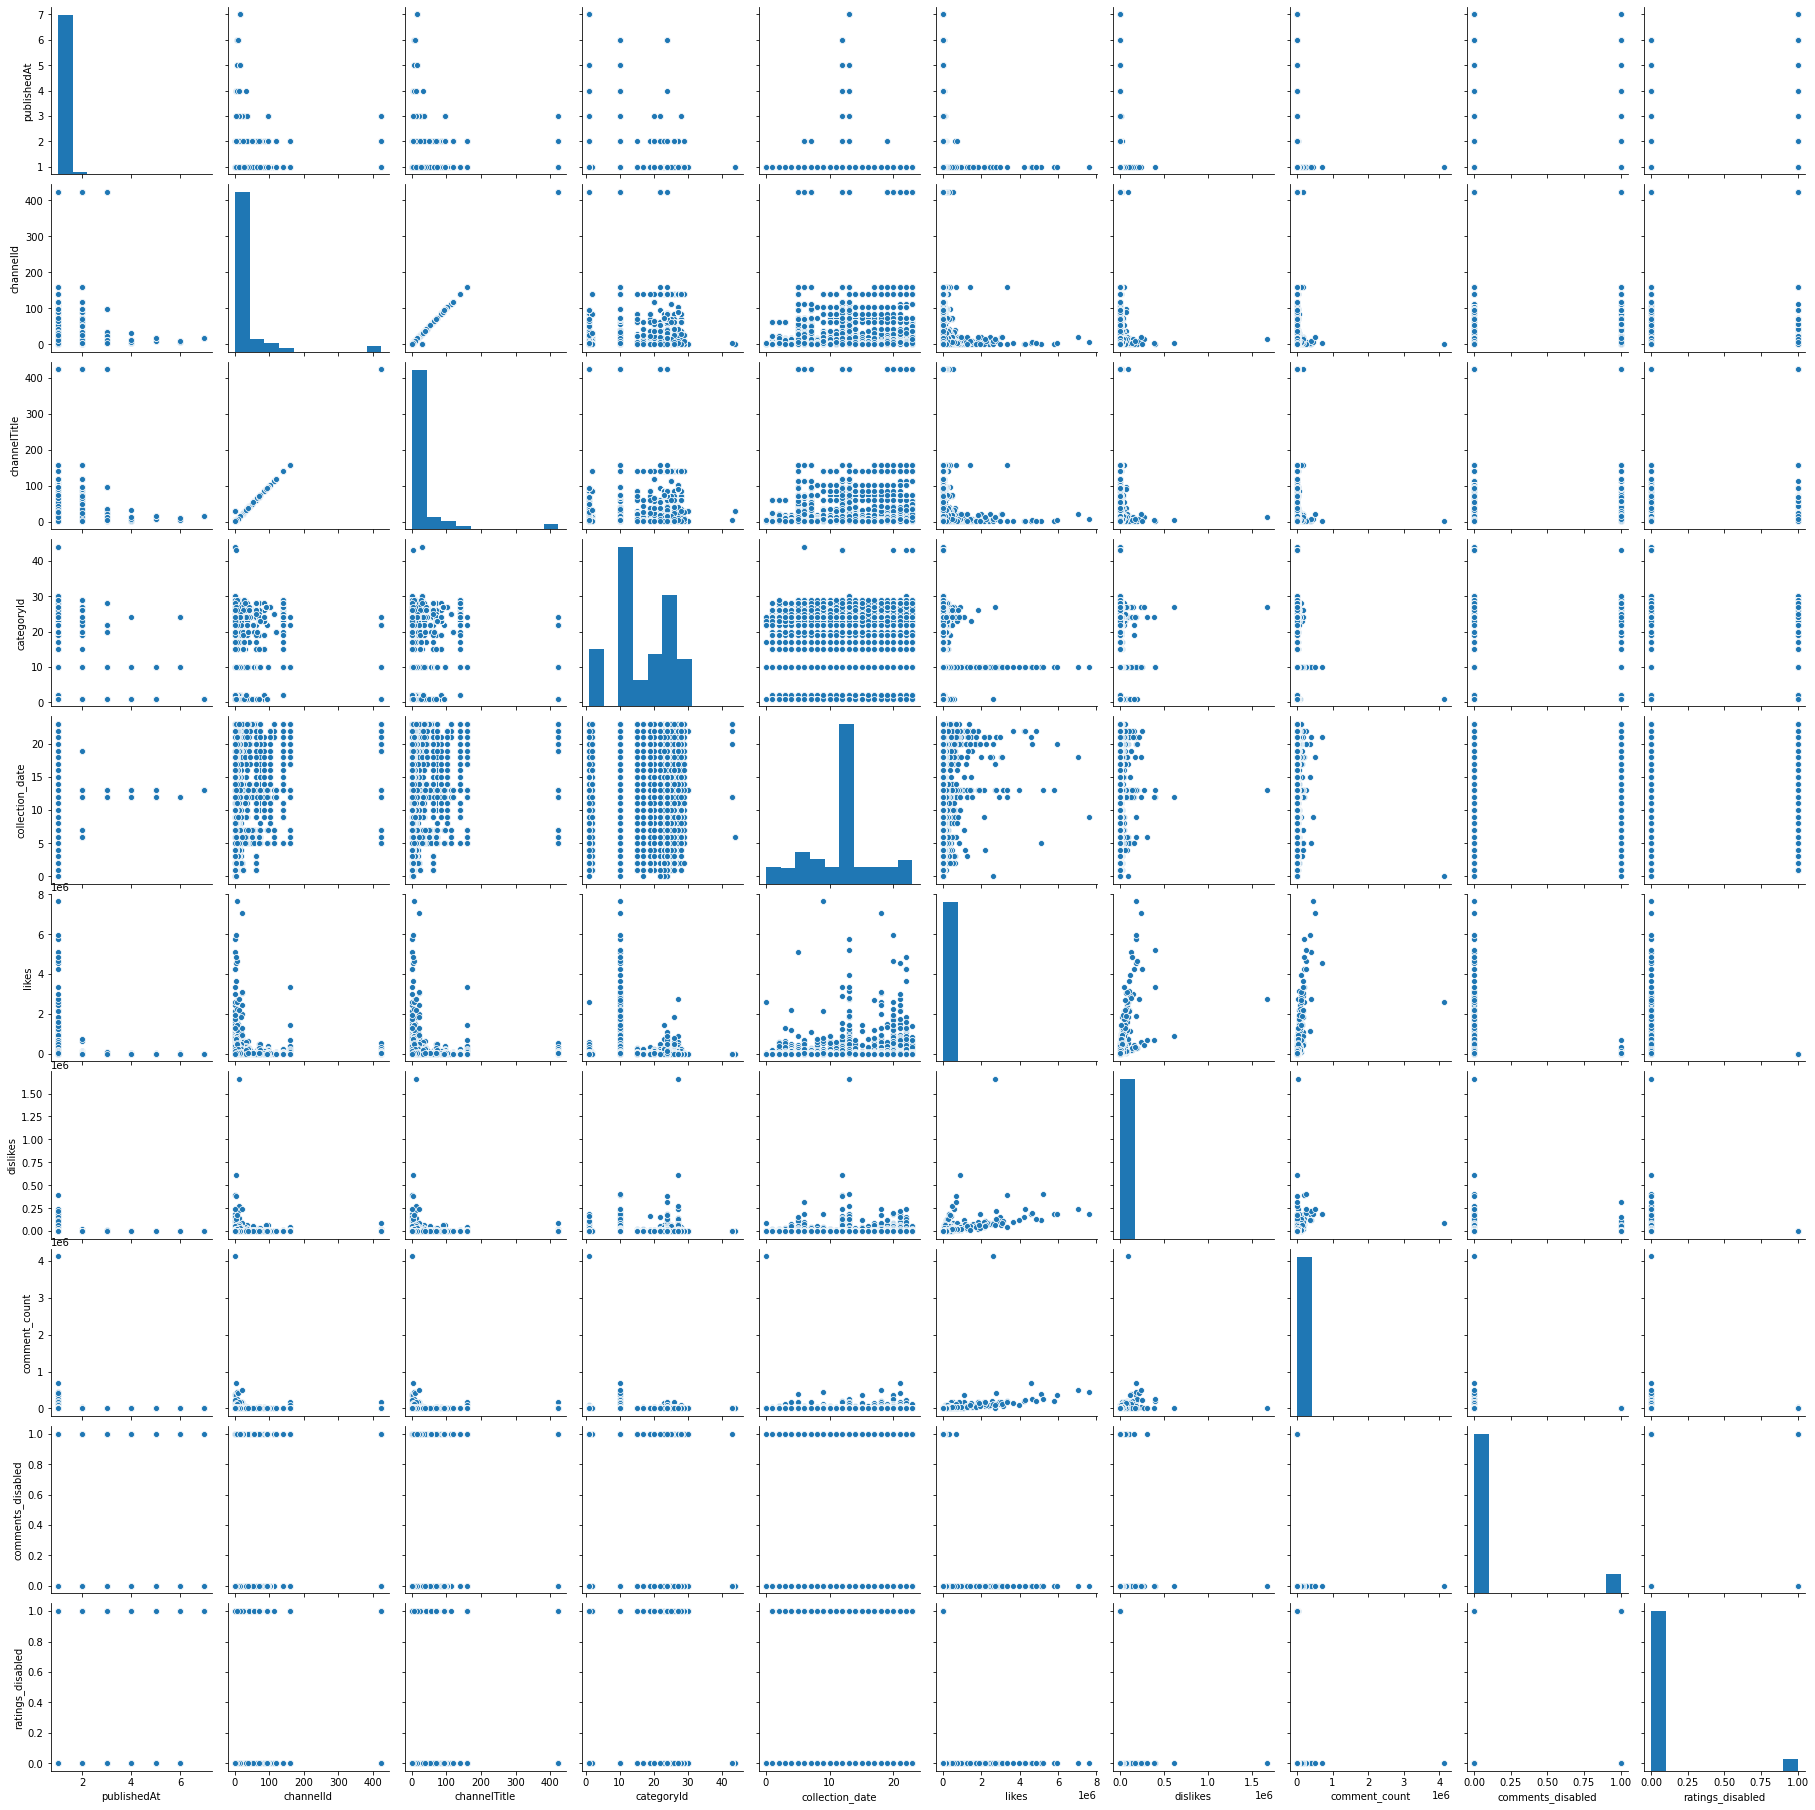

In [42]:
pg = sns.pairplot(df)

       publishedAt  channelId  ...  ratings_disabled        y
0              NaN        NaN  ...                 0    29229
1              NaN        NaN  ...                 0   730280
2              NaN        NaN  ...                 0    80667
3              NaN        NaN  ...                 0    34826
4              NaN        NaN  ...                 0   172727
...            ...        ...  ...               ...      ...
19715          NaN        NaN  ...                 0    59108
19716          NaN        NaN  ...                 0  7625988
19717          NaN        NaN  ...                 0  1484041
19718          NaN        NaN  ...                 0      125
19719          NaN        NaN  ...                 0  1247137

[19720 rows x 11 columns]


IndexError: ignored

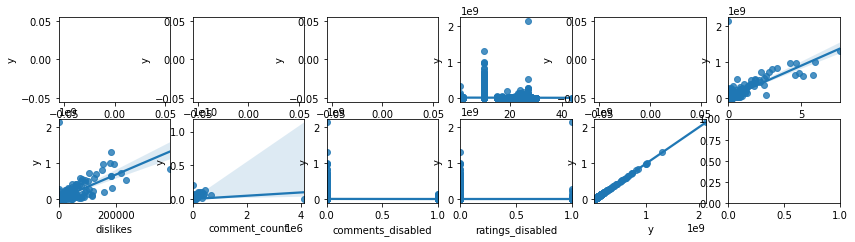

In [46]:
for c in ['comments_disabled','ratings_disabled']: #,'tags'
  le = LabelEncoder()
  le.fit(train_x[c].fillna('NA'))
  train[c] = le.transform(train[c].fillna('NA'))
for c in ['publishedAt','channelId','channelTitle','collection_date']:
  freq = train_x[c].value_counts()
  train[c] = train[c].map(freq)

del train["video_id"]
del train["title"]
del train["description"]
del train["thumbnail_link"]
del train["tags"]
del train["id"]
train_n = train.select_dtypes(include=[np.number])
print(train_n)
#グラフを作る
fig = plt.figure(figsize=(14,9))
for i in np.arange(30):  #30が最大
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=train_n.iloc[:,i], y=train_n.y)

#グラフを整えて表示
plt.tight_layout()
plt.show()

## モデル

In [36]:
#rmse_scores = []
#pred_cv = np.zeros(len(test_x.index))
def LGB_Model(train_x,train_y,test_x,seed):
  rmse_scores = []
  preds = []
  preds_test = []
  va_idxes = []
  pred_cv = np.zeros(len(test_x.index))


  fold_num = 4
  kf = KFold(n_splits=fold_num, shuffle=True, random_state=71)
  for n_fold, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
      tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
      tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
      lgb_train = lgb.Dataset(tr_x,tr_y)
      lgb_eval = lgb.Dataset(va_x,va_y)

      params = {
          'obejective':'rmse',
          'seed':seed,
          'verbose':1,
          'metrics':'rmse',
          'max_depth' : 30,
          #'num_leaves' : 20 # 付け足した5/01
      }

      lgb_model = lgb.train(
          params,
          lgb_train,
          num_boost_round = 10000,
          valid_names=['train','valid'],
          valid_sets=[lgb_train,lgb_eval],
          verbose_eval= 1000,
          early_stopping_rounds=1000
                     )
      va_pred = lgb_model.predict(va_x)
      mse = mean_squared_error(va_y, va_pred)
      rmse = np.sqrt(mse)
      rmse_scores.append(rmse)
      
      submission = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration) 
      pred_cv += submission/fold_num
      print(n_fold+1,"回目のrmsle:",rmse)

  print("LGB rmsle平均:",np.mean(rmse_scores))
  lgb.plot_importance(lgb_model,max_num_features=71, grid=False, figsize=(6,8))
  return pred_cv
pred_cv = LGB_Model(train_x,train_y,test_x,71)

ValueError: ignored

In [26]:
print(len(train_x['channelId'].unique()))
print(len(train_x['channelId']))

9070
19720


In [27]:
print(len(train_x['channelTitle'].unique()))
print(len(train_x['channelTitle']))

9045
19720


Training until validation scores don't improve for 1000 rounds.
[1000]	train's rmse: 0.56232	valid's rmse: 0.857101
Early stopping, best iteration is:
[313]	train's rmse: 0.681667	valid's rmse: 0.839149
1 回目のrmsle: 0.8391492383007344
Training until validation scores don't improve for 1000 rounds.
[1000]	train's rmse: 0.554602	valid's rmse: 0.863266
Early stopping, best iteration is:
[316]	train's rmse: 0.680577	valid's rmse: 0.847589
2 回目のrmsle: 0.847589172120859
Training until validation scores don't improve for 1000 rounds.
[1000]	train's rmse: 0.559555	valid's rmse: 0.86645
Early stopping, best iteration is:
[328]	train's rmse: 0.673224	valid's rmse: 0.859658
3 回目のrmsle: 0.8596576513472943
Training until validation scores don't improve for 1000 rounds.
[1000]	train's rmse: 0.562629	valid's rmse: 0.849819
Early stopping, best iteration is:
[354]	train's rmse: 0.676403	valid's rmse: 0.834874
4 回目のrmsle: 0.8348741726303608
LGB rmsle平均: 0.8453175585998122


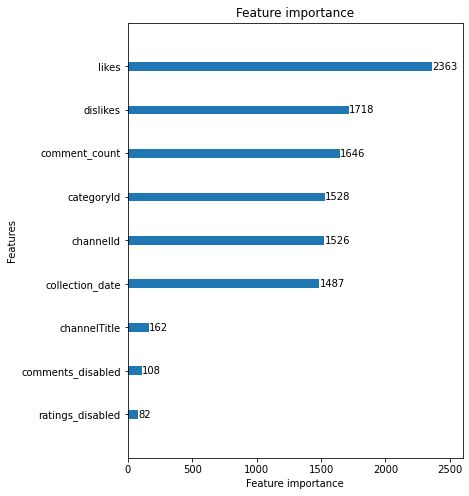

In [33]:
del train_x["publishedAt"]
del test_x["publishedAt"]
def LGB_Model(train_x,train_y,test_x,seed):
  rmse_scores = []
  preds = []
  preds_test = []
  va_idxes = []
  pred_cv = np.zeros(len(test_x.index))


  fold_num = 4
  kf = KFold(n_splits=fold_num, shuffle=True, random_state=71)
  for n_fold, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
      tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
      tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
      lgb_train = lgb.Dataset(tr_x,tr_y)
      lgb_eval = lgb.Dataset(va_x,va_y)

      params = {
          'obejective':'rmse',
          'seed':seed,
          'verbose':1,
          'metrics':'rmse',
          'max_depth' : 30,
          #'num_leaves' : 20 # 付け足した5/01
      }

      lgb_model = lgb.train(
          params,
          lgb_train,
          num_boost_round = 10000,
          valid_names=['train','valid'],
          valid_sets=[lgb_train,lgb_eval],
          verbose_eval= 1000,
          early_stopping_rounds=1000
                     )
      va_pred = lgb_model.predict(va_x)
      mse = mean_squared_error(va_y, va_pred)
      rmse = np.sqrt(mse)
      rmse_scores.append(rmse)
      
      submission = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration) 
      pred_cv += submission/fold_num
      print(n_fold+1,"回目のrmsle:",rmse)

  print("LGB rmsle平均:",np.mean(rmse_scores))
  lgb.plot_importance(lgb_model,max_num_features=71, grid=False, figsize=(6,8))
  return pred_cv
pred_cv = LGB_Model(train_x,train_y,test_x,71)

## 提出